In [1]:
%matplotlib inline

import pandas as pd
from pandas import Series,DataFrame

import numpy as np

# Carregando o arquivo csv...

In [16]:
# foi necessário utilizar os seguintes parâmetros:
# a) index_col=False - deixa de pegar a primeira coluna para ser o índice das linhas
# b) header=None - indica que a primeira linha do arquivo não contém o nome das colunas
# c) names=[...] - seta o nome das colunas
df = pd.read_csv('D:/Users/samuelmm/Desktop/car.csv', index_col=False, header=None, names=['buying','maint','doors','persons','lug_boot','safety','target'])

In [20]:
print(df.dtypes)
print(df)

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object
     buying  maint  doors persons lug_boot safety
0     vhigh  vhigh      2       2    small    low
1     vhigh  vhigh      2       2    small    med
2     vhigh  vhigh      2       2    small   high
3     vhigh  vhigh      2       2      med    low
4     vhigh  vhigh      2       2      med    med
5     vhigh  vhigh      2       2      med   high
6     vhigh  vhigh      2       2      big    low
7     vhigh  vhigh      2       2      big    med
8     vhigh  vhigh      2       2      big   high
9     vhigh  vhigh      2       4    small    low
10    vhigh  vhigh      2       4    small    med
11    vhigh  vhigh      2       4    small   high
12    vhigh  vhigh      2       4      med    low
13    vhigh  vhigh      2       4      med    med
14    vhigh  vhigh      2       4      med   high
15    vhigh  vhigh      2       4      big    low
16    vhigh  vhigh    

In [18]:
target = df['target']

In [19]:
# deletando a coluna que contém a variável 'target'
# OBS: o segundo parâmetro da função diz em qual eixo procurar o objeto a ser deletado
## 0 -> eixo x (linhas)
## 1 -> eixo y (colunas)
df = df.drop('target', 1)

# Transformação dos dados...

In [21]:
# transformando o tipo de todas as colunas para 'category'
for x in df.columns:
    df[x] = pd.Categorical(df[x])

In [36]:
df.dtypes

buying      category
maint       category
doors       category
persons     category
lug_boot    category
safety      category
dtype: object

# Análise dos dados...

In [7]:
# utilizando função para descrever todos os campos do DataFrame
df.describe()

,buying,maint,doors,persons,lug_boot,safety
count,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3
top,vhigh,vhigh,5more,more,small,med
freq,432,432,432,576,576,576


In [22]:
# como todas as variáveis são categóricas, deve-se analisar quantas vezes
# cada uma aparece no dataframe
for x in df.columns:
    print("Nome da coluna: {}.\n{}".format(x, df[x].value_counts()))

Nome da coluna: buying.
vhigh    432
med      432
low      432
high     432
dtype: int64
Nome da coluna: maint.
vhigh    432
med      432
low      432
high     432
dtype: int64
Nome da coluna: doors.
5more    432
4        432
3        432
2        432
dtype: int64
Nome da coluna: persons.
more    576
4       576
2       576
dtype: int64
Nome da coluna: lug_boot.
small    576
med      576
big      576
dtype: int64
Nome da coluna: safety.
med     576
low     576
high    576
dtype: int64


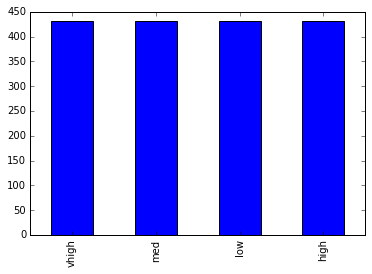

In [9]:
# exemplo de como plotar os dados de uma variável categórica
df['buying'].value_counts().plot(kind='bar')

# Construção do modelo...

Nesse exemplo, vamos utilizar o algoritmo Random Forest.

De início, será necessário realizar pré-processamento dos dados, para transformar o DataFrame do 'pandas' em uma estrutura de dados que o scikit-learn possa ler. Para isso, vamos utilizar o pacote sklearn-pandas (classe DataFrameMapper), juntamente com a classe Pipeline do scikit-learn.

O que iremos fazer é transformar as variáveis categóricas em formato numérico, já que os métodos fit() dos modelos do scikit-learn esperam um NumPy array como entrada.

In [26]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn_pandas import DataFrameMapper, cross_val_score

In [23]:
# utilizando classe do pacote sklearn-pandas para mapear cada
# coluna do DataFrame em um 'transformer' do scikit-learn
mapper = DataFrameMapper([
        ('buying', preprocessing.LabelBinarizer()),
        ('maint', preprocessing.LabelBinarizer()),
        ('doors', preprocessing.LabelBinarizer()),
        ('persons', preprocessing.LabelBinarizer()),
        ('lug_boot', preprocessing.LabelBinarizer()),
        ('safety', preprocessing.LabelBinarizer())
    ])

In [25]:
# testando para ver se a transformação funcionou
np.round(mapper.fit_transform(df.copy()), 2)

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ..., 
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 0, 0]])

In [27]:
# montando o pipeline que aplica a transformação no DataFrame e, na sequência,
# inicializa o estimador da classe RandomForestClassifier
pipe = Pipeline([
        ('featurize', mapper),
        ('rf', RandomForestClassifier(n_estimators=10))
    ])

In [30]:
# separando os dados de treino dos dados de teste
# -- setando 70% / 30% para dados de treino / teste
df_treino, df_teste, y_treino, y_teste = train_test_split(df, target, test_size=0.3, random_state=100)

In [81]:
# treinando o modelo, usando 5-fold-cross-validation para validá-lo
scores_treino = cross_val_score(pipe, df_treino, y_treino, cv=5)

In [86]:
# checando a média dos escores obtidos com o cross-validation do modelo - dados de treino
# -- é necessário arredondar os resultados para 2 casas decimais, de forma a não causar diferença
# -- quando o código rodar em outra máquina, tendo em vista as diferenças de hardware gerarem cálculos
# -- ligeiramente diferentes
np.round(scores_treino.mean(), 2)

0.93999999999999995

In [87]:
# usando o modelo nos dados de teste
# -- avaliação com 2-fold-cross-validation
scores_teste = cross_val_score(pipe, df_teste, y_teste, cv=2)

In [91]:
# checando a média dos escores obtidos com o cross-validation do modelo - dados de teste
np.round(scores_teste.mean(), 2)

0.85999999999999999